In [28]:
import pandas as pd
import pybedtools
import pathlib
import pyBigWig
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
peaks_df = pd.read_csv('Satb2_chip_peaks.bed', header=None, sep='\t', index_col=3)
peaks_bed = pybedtools.BedTool.from_dataframe(peaks_df)

peaks_df[0].unique()

use_chroms = [
    'chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
    'chr17', 'chr18', 'chr19', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7',
    'chr8', 'chr9', 'chrX', 'chrY'
]
peaks_df = peaks_df[peaks_df[0].isin(use_chroms)].copy()

peaks_df.head()

,0,1,2,4
3,,,,
peak1,chr1,11748399,11748801,16.20620
peak2,chr1,12410048,12410387,7.83612
peak3,chr1,14116686,14116991,22.82489
peak4,chr1,24612506,24613336,129.45082
peak5,chr1,26687061,26688119,12.15494


In [3]:
bw_dir = pathlib.Path('/home/hanliu/ddn/hanliu/mouse_rostral_brain/MultiLevelCluster/BW/SubType/')
bw_dict = {p.name.split('.')[1]:str(p) for p in bw_dir.glob('*CGN-Both.rate.bw')}

## Calculate

In [6]:
def get_values_single_bw(bw_path, bed):
    with pyBigWig.open(bw_path) as bw:
        record = {}
        for peak_id, (chrom, start, end, _) in bed.iterrows():
            record[peak_id] = bw.stats(chrom, start, end, type="mean")[0]
    return pd.Series(record)

In [7]:
# total_records = []
# for cluster_name, bw_path in bw_dict.items():
#     print(cluster_name)
#     record = get_values_single_bw(bw_path, peaks_df)
#     record.name = cluster_name
#     total_records.append(record)
# total_records = pd.DataFrame(total_records)
# total_records.to_hdf('Satb2_chip_peaks.mCG_rate.hdf', key='data')

In [60]:
total_records = pd.read_hdf('Satb2_chip_peaks.mCG_rate.hdf', key='data')

## Plot

In [61]:
import joblib
exc_order = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)['ivl']
inh_order = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)['ivl']

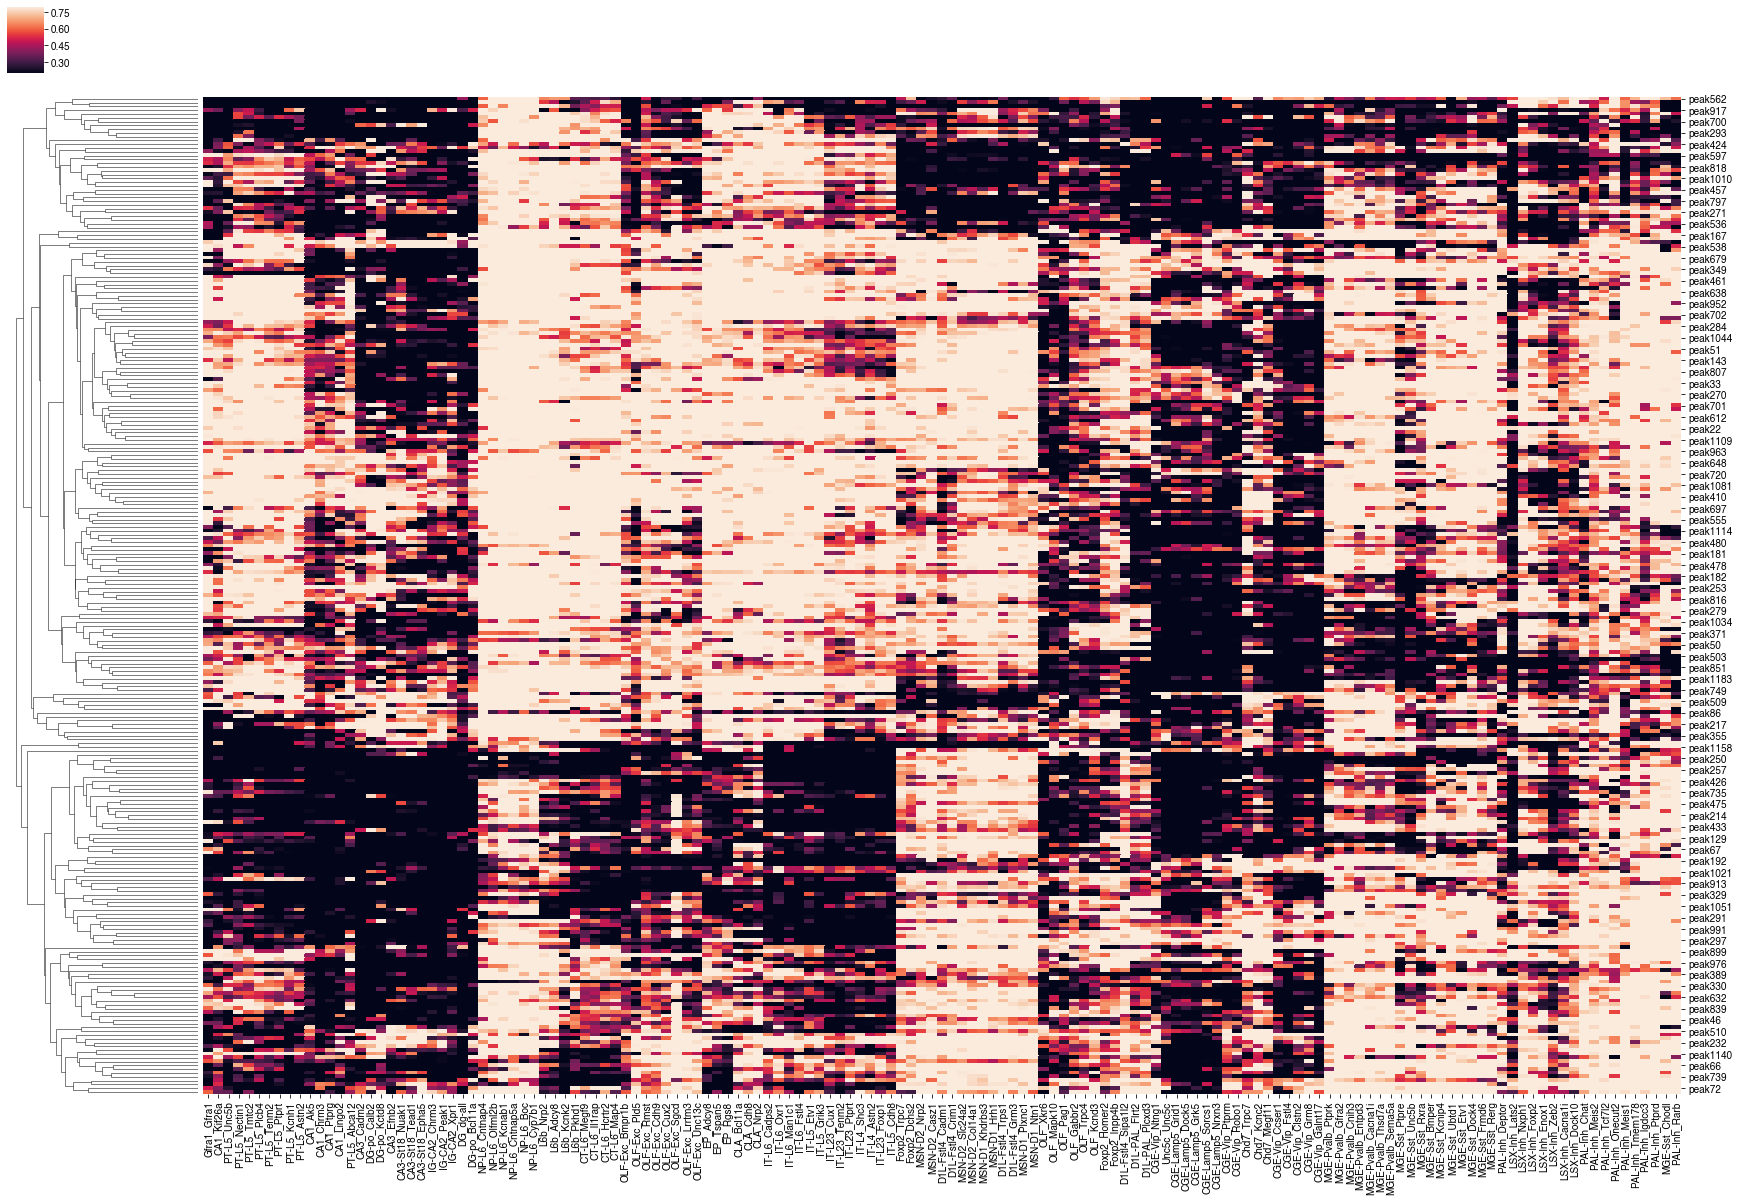

In [73]:
# filter
nan_judge = total_records.isna().sum() < 10
std_judge = total_records.std() > 0.3

filtered_records = total_records.loc[:, nan_judge & std_judge].copy()

# fill na
filtered_records = filtered_records.fillna(filtered_records.mean())

name_map = {i.replace(' ', '.').replace('_', '.').replace('-', '.'):i for i in filtered_records.index}
cluster_order = [name_map[i] for i in (exc_order + inh_order)]
filtered_records = filtered_records.loc[cluster_order].T

sns.clustermap(filtered_records, figsize=(30, 20), col_cluster=False, vmin=0.2, vmax=0.8)

In [74]:
total_records.std().describe()

count    1169.000000
mean        0.208899
std         0.111247
min         0.000000
25%         0.115599
50%         0.242155
75%         0.295041
max         0.577350
dtype: float64